<a href="https://colab.research.google.com/github/shahmeerkhan12/Machine-Learning/blob/main/deep_recommendation_sys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing dependencies

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shahmeerkan","key":"54cd46bd75aa3241e9c279447dd10405"}'}

# Loading Dataset


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d retailrocket/ecommerce-dataset
!unzip ecommerce-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset
License(s): CC-BY-NC-SA-4.0
 81% 234M/291M [00:00<00:00, 1.13GB/s]
100% 291M/291M [00:00<00:00, 1.13GB/s]
Archive:  ecommerce-dataset.zip
  inflating: category_tree.csv       
  inflating: events.csv              
  inflating: item_properties_part1.csv  
  inflating: item_properties_part2.csv  


In [ ]:
import pandas as pd
import numpy as np
# !pip install -q tensorflow
from sklearn.model_selection import train_test_split


In [ ]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 836.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 117.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 113.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 121.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.9 MB/s eta 0:00:00


Prepare Data for Model




```
# This is formatted as code
```

# processing the data for NCF

In [ ]:
def prepare_ncf_data(data):
    # Create user and item mappings
    user_ids = data['visitorid'].unique()
    item_ids = data['itemid'].unique()

    user_to_index = {user: idx for idx, user in enumerate(user_ids)}
    item_to_index = {item: idx for idx, item in enumerate(item_ids)}

    # Map IDs to indices
    data['user_index'] = data['visitorid'].map(user_to_index)
    data['item_index'] = data['itemid'].map(item_to_index)

    # Split data
    train, test = train_test_split(data, test_size=0.2, random_state=42)

    return train, test, len(user_ids), len(item_ids)

# Build the NCF model

In [ ]:
# 3. Build NCF model
def build_ncf_model(num_users, num_items):
    # User pathway
    user_input = Input(shape=(1,), name='user_input')
    user_embedding = Embedding(num_users, 32, name='user_embedding')(user_input)
    user_vec = Flatten()(user_embedding)

    # Item pathway
    item_input = Input(shape=(1,), name='item_input')
    item_embedding = Embedding(num_items, 32, name='item_embedding')(item_input)
    item_vec = Flatten()(item_embedding)

    # Concatenate and add dense layers
    concat = Concatenate()([user_vec, item_vec])
    dense1 = Dense(64, activation='relu')(concat)
    output = Dense(1, activation='sigmoid')(dense1)

    # Compile model
    model = Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


# Data Exploration Visualization

In [ ]:
# data exploration visualization
import matplotlib.pyplot as plt
import seaborn as sns
!pip install wordcloud
from wordcloud import WordCloud
def load_and_preprocess_data():
    # Load datasets
    events = pd.read_csv('events.csv')
    item_properties1 = pd.read_csv('item_properties_part1.csv')
    item_properties2 = pd.read_csv('item_properties_part2.csv')
    category_tree = pd.read_csv('category_tree.csv')

    # Fix 1: Handle SettingWithCopyWarning properly
    positive_events = events[events['event'].isin(['addtocart', 'transaction'])].copy()
    positive_events.loc[:, 'label'] = 1  # Proper way to add column

    # Process item properties
    item_properties = pd.concat([item_properties1, item_properties2])
    item_properties = item_properties.sort_values('timestamp')

    item_features = (item_properties.groupby(['itemid', 'property'])['value']
                    .last()
                    .unstack()
                    .reset_index())

    # Fix 2: Ensure categoryid exists before processing
    if 'categoryid' in item_features.columns:
        item_features['categoryid'] = item_features['categoryid'].astype('category').cat.codes
    else:
        item_features['categoryid'] = 0  # Default value

    if 'available' in item_features.columns:
        item_features['available'] = item_features['available'].map({'true': 1, 'false': 0})
    else:
        item_features['available'] = 0  # Default value

    return positive_events, item_features

def plot_data_insights(data, item_features):
    plt.figure(figsize=(15, 12))

    # 1. Event Type Distribution
    plt.subplot(2, 2, 1)
    sns.countplot(x='event', data=data, order=data['event'].value_counts().index)
    plt.title('Distribution of Event Types')

    # 2. User Activity Timeline
    plt.subplot(2, 2, 2)
    data['date'] = pd.to_datetime(data['timestamp'], unit='ms')
    data.resample('D', on='date')['visitorid'].nunique().plot()
    plt.title('Daily Active Users')

    # 3. Item Popularity
    plt.subplot(2, 2, 3)
    data['itemid'].value_counts()[:20].plot(kind='barh')
    plt.title('Top 20 Most Popular Items')

    # 4. Category Distribution (only if categories exist)
    plt.subplot(2, 2, 4)
    if 'categoryid' in item_features.columns and item_features['categoryid'].nunique() > 0:
        text = ' '.join(str(cat) for cat in item_features['categoryid'].dropna())
        if text.strip():  # Only plot if we have valid text
            wordcloud = WordCloud(width=800, height=400).generate(text)
            plt.imshow(wordcloud)
            plt.title('Category Distribution')
        else:
            plt.text(0.5, 0.5, 'No category data available', ha='center')
    else:
        plt.text(0.5, 0.5, 'No category data available', ha='center')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('data_insights.png', dpi=300)
    plt.show()


# Visualizing the Model performance

In [ ]:
  # model performance visualization
def plot_model_performance(history, test_predictions, test_labels):
    plt.figure(figsize=(15, 5))

    # 1. Training History
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epochs')
    plt.ylabel('Binary Crossentropy')
    plt.legend()

    # 2. Prediction Distribution
    plt.subplot(1, 2, 2)
    sns.histplot(test_predictions, bins=50, kde=True)
    plt.title('Distribution of Predicted Scores')
    plt.xlabel('Prediction Score')

    plt.tight_layout()
    plt.savefig('model_performance.png', dpi=300)
    plt.show()

# Main Function

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 32)     │  1,243,680 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (None, 1, 32)     │    778,112 │ item_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 32)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 32)        │          0 │ item_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64)        │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      4,160 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,026,017 (7.73 MB)

 Trainable params: 2,026,017 (7.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9107 - loss: 0.6109 - val_accuracy: 1.0000 - val_loss: 0.2592
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 1.0000 - loss: 0.1544 - val_accuracy: 1.0000 - val_loss: 0.0529
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 1.0000 - loss: 0.0188 - val_accuracy: 1.0000 - val_loss: 0.0278
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 1.0000 - val_loss: 0.0208
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 0.0175
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0156
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0144
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 1.0000 - loss: 8.3482e-04 - val_accuracy: 1.0000

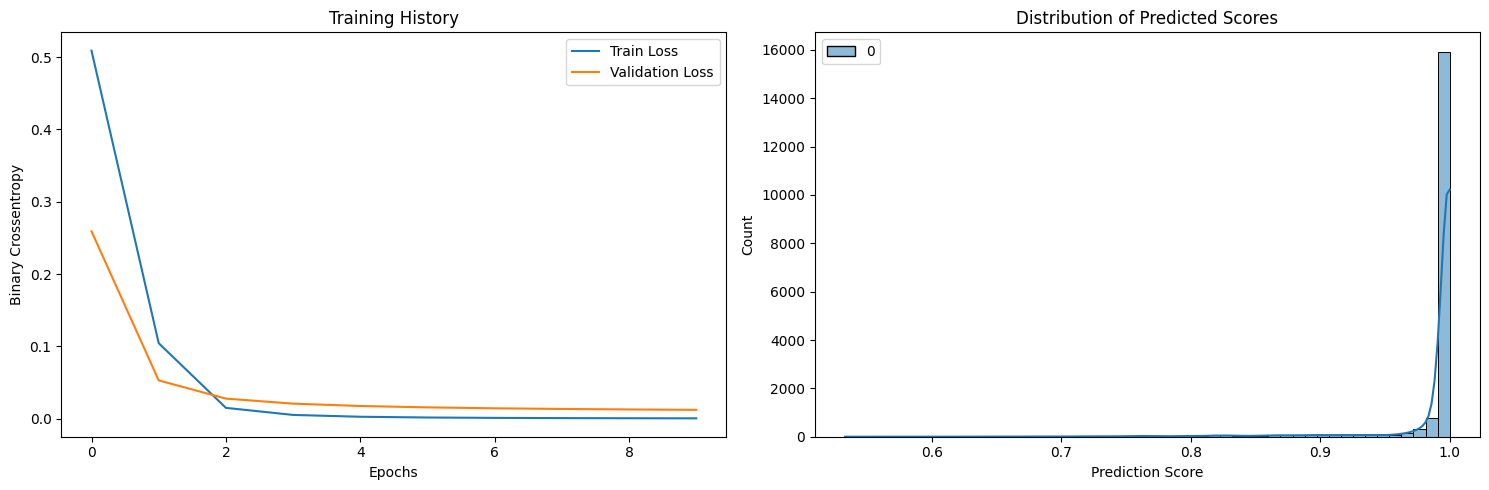

In [ ]:
# 4. Main execution
def main():
  # Load and preprocess data
    data, item_features = load_and_preprocess_data()
    # first visualization of raw data
    # plot_data_insights(data, item_features)

    # Prepare NCF data
    train, test, num_users, num_items = prepare_ncf_data(data)

    # Build and train model
    model = build_ncf_model(num_users, num_items)
    model.summary()

    history = model.fit(
        [train['user_index'], train['item_index']],
        train['label'],
        validation_data=([test['user_index'], test['item_index']], test['label']),
        epochs=10,
        batch_size=1024
    )
      # --- SECOND VISUALIZATION: MODEL PERFORMANCE ---
    print("\nGenerating model performance visualizations...")
    test_predictions = model.predict([test['user_index'], test['item_index']])
    plot_model_performance(history, test_predictions, test['label'])
    return model, history

# Run the pipeline
model, history = main()